In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from trainTestValSplit import getTrainTestValSplit
from definitions import ROOT_DIR
from preProcessing import preProcess
from definitions import main_activity_label_classes

In [2]:
# We need to get rid of all the NAN values

train, test, val = getTrainTestValSplit(_dataset_path=f'{ROOT_DIR}/dataset/ExtraSensory/ExtraSensory.per_uuid_features_labels')
total = pd.concat([train, test, val])
total= total.drop(total.filter(regex='label:').columns, axis=1)
del train, test, val

In [3]:
#Get rid of every column with more than 50% NAN values
drop_cols = (total.isnull().sum() / total.shape[0]) > 0.5
drop_cols = drop_cols[drop_cols == True].index
total = total.drop(columns=drop_cols)

In [34]:
# Get rid of 'location' since we have the relative location given 'location (quick)
location_columns= [col for col in total.columns if 'location:' in col]
total = total.drop(columns= location_columns)

In [5]:
# Every value for proximity is 0 in the dataset, so we can delete this
total = total.drop(columns= ['lf_measurements:proximity'])

In [68]:
# these variables show normality, hence the mean is used to fill NA values
total['location_quick_features:lat_change'].fillna(value= total['location_quick_features:lat_change'].mean(), inplace= True)
total['location_quick_features:long_change'].fillna(value= total['location_quick_features:long_change'].mean(), inplace= True)

In [85]:
df = total[total.isnull().sum(axis=1) < 46]

In [8]:
relative_nan = (df.isnull().sum() / df.shape[0])
relative_nan[relative_nan > 0]

proc_gyro:magnitude_stats:mean               0.033338
proc_gyro:magnitude_stats:std                0.033338
proc_gyro:magnitude_stats:moment3            0.033338
proc_gyro:magnitude_stats:moment4            0.033338
proc_gyro:magnitude_stats:percentile25       0.033338
                                               ...   
audio_naive:mfcc12:std                       0.013193
audio_properties:max_abs_value               0.008365
audio_properties:normalization_multiplier    0.008365
lf_measurements:battery_level                0.000075
lf_measurements:screen_brightness            0.447070
Length: 102, dtype: float64

In [ ]:
#We need to get rid of outliers

In [3]:
train, test, val = getTrainTestValSplit(_dataset_path=f'{ROOT_DIR}/dataset/ExtraSensory/ExtraSensory.per_uuid_features_labels')

In [4]:
# drop columns with more than 50% NA values
train2 = train.drop(train.filter(regex='label:').columns, axis=1) # Do not take label in account
drop_cols = (train2.isnull().sum() / train2.shape[0]) > 0.5 #Columns with more than 50% missing values
drop_cols = drop_cols[drop_cols == True].index
train = train.drop(columns=drop_cols)
del train2

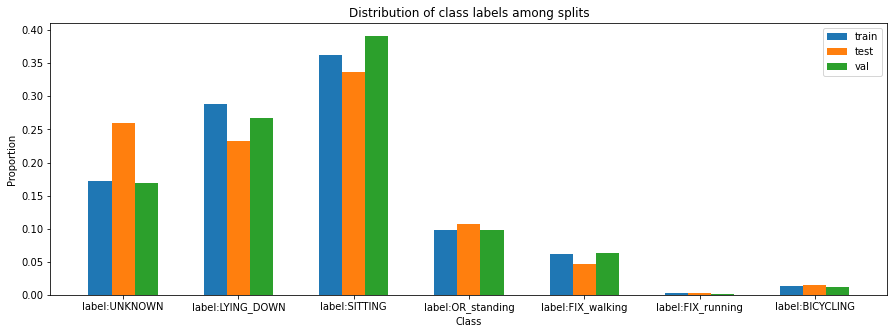

In [5]:
# What is the label distribution?
train_x, train_y = preProcess(train)
test_x, test_y = preProcess(test)
val_x, val_y = preProcess(val)
del train_x, test_x, val_x

train_y = train_y.value_counts(normalize=True).sort_index()
test_y  = test_y.value_counts(normalize=True).sort_index()
val_y =  val_y.value_counts(normalize=True).sort_index()

X = main_activity_label_classes.keys()
X_axis = np.arange(len(X))

plt.figure(figsize=(15,5))
plt.bar(X_axis-0.2, train_y, width=0.2, label= 'train')
plt.bar(X_axis, test_y, width=0.2, label= 'test')
plt.bar(X_axis+0.2, val_y, width=0.2, label= 'val')
plt.xticks(X_axis, X)
plt.legend()
plt.ylabel('Proportion')
plt.xlabel('Class')
plt.title('Distribution of class labels among splits')
plt.show()

timestamp
raw_acc:magnitude_stats:mean
raw_acc:magnitude_stats:std
raw_acc:magnitude_stats:moment3
raw_acc:magnitude_stats:moment4
raw_acc:magnitude_stats:percentile25
raw_acc:magnitude_stats:percentile50
raw_acc:magnitude_stats:percentile75
raw_acc:magnitude_stats:value_entropy
raw_acc:magnitude_stats:time_entropy
raw_acc:magnitude_spectrum:log_energy_band0
raw_acc:magnitude_spectrum:log_energy_band1
raw_acc:magnitude_spectrum:log_energy_band2
raw_acc:magnitude_spectrum:log_energy_band3
raw_acc:magnitude_spectrum:log_energy_band4
raw_acc:magnitude_spectrum:spectral_entropy
raw_acc:magnitude_autocorrelation:period
raw_acc:magnitude_autocorrelation:normalized_ac
raw_acc:3d:mean_x
raw_acc:3d:mean_y
raw_acc:3d:mean_z
raw_acc:3d:std_x
raw_acc:3d:std_y
raw_acc:3d:std_z
raw_acc:3d:ro_xy
raw_acc:3d:ro_xz
raw_acc:3d:ro_yz
proc_gyro:magnitude_stats:mean
proc_gyro:magnitude_stats:std
proc_gyro:magnitude_stats:moment3
proc_gyro:magnitude_stats:moment4
proc_gyro:magnitude_stats:percentile25
proc_g

In [ ]:
train